In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler

In [17]:
# Path to the tsv file containing subject data
tsv_file_path = '/kaggle/input/openbhb/official_site_class_labels.tsv'  
subject_data = pd.read_csv(tsv_file_path, sep='\t')
subject_ids = subject_data['participant_id'].values  # Extract the subject IDs

In [18]:
#To limit datadet size 
subject_ids= subject_ids[:200] 

In [19]:
def crop(volume, start_x=16, end_x=163, start_y=17, end_y=202, start_z=0, end_z=157):
    volume = volume.squeeze()
    cropped_volume = volume[start_x:end_x, start_y:end_y, start_z:end_z]
    return cropped_volume.unsqueeze(0)

In [2]:
def crop_brain_scan(volume):
    
#     Crops a 3D brain scan, removing black regions while preserving useful information.

    volume = volume.squeeze()  # Remove the batch dimension if present

    # Find non-zero indices
    nonzero_indices = torch.nonzero(volume > 0)

    # Determine crop dimensions
    min_x, min_y, min_z = nonzero_indices.min(dim=0)[0]
    max_x, max_y, max_z = nonzero_indices.max(dim=0)[0]

    # Crop the volume
    cropped_volume = volume[min_x:max_x+1, min_y:max_y+1, min_z:max_z+1]

    return cropped_volume.unsqueeze(0)

In [21]:
class BrainMRIDataset(Dataset):
    def __init__(self, subject_ids, base_path, target_size=(128, 128, 128), slice_depth=16, transform=None):
        self.subject_ids = subject_ids
        self.base_path = base_path
        self.target_size = target_size  # Target shape should be (128, 128, 128)
        self.slice_depth = slice_depth  # Depth of each slice (e.g., 8)
        self.transform = transform

    def __len__(self):
        # Return total number of subjects
        return len(self.subject_ids)
    
    def get_slices(self, mri_volume):
        # Ensure mri_volume shape is [128, 128, 128]
        if len(mri_volume.shape) != 3:
            mri_volume = mri_volume.squeeze()

        patches = []
        # Slice along the depth axis (axis 2) into smaller chunks of depth `slice_depth`
        for i in range(mri_volume.shape[2] // self.slice_depth):
            start = i * self.slice_depth
            end = start + self.slice_depth
            patch = mri_volume[:, :, start:end]  # Slicing along the depth axis
            patches.append(patch)  # Append patch with shape [128, 128, slice_depth]
        return patches

    def __getitem__(self, index):
        subject_id = self.subject_ids[index]
        file_path = f"{self.base_path}/sub-{subject_id}_preproc-quasiraw_T1w.npy"
        
        # Load the .npy file
        mri_volume = np.load(file_path)  # Shape: (1, 1, 182, 218, 182)
        
        # Convert to tensor and remove redundant dimension
        mri_volume = torch.tensor(mri_volume).float().squeeze(0)

        # Removing unwanted pixels
        mri_volume= crop_brain_scan(mri_volume)

        # Resize to target shape (128x128x128)
        mri_volume = F.interpolate(mri_volume.unsqueeze(0), size=self.target_size, mode='trilinear', align_corners=False).squeeze(0)
        
        # Normalize the volume
        mri_volume = (mri_volume - mri_volume.min()) / (mri_volume.max() - mri_volume.min() + 1e-8)

        # Slice the volume along the depth axis into smaller chunks (128x128x8)
        mri_slices = self.get_slices(mri_volume)

        # Transform if any is provided
        if self.transform:
            mri_slices = [self.transform(slice) for slice in mri_slices]

        # Add channel dimension back to each slice
        mri_slices = [slice.unsqueeze(0) for slice in mri_slices]  # Shape [1, 128, 128, 8]

        return mri_slices


In [22]:
# Split dataset into train and validation sets
def split_dataset(dataset, val_split=0.2):
    val_size = int(len(dataset) * val_split)
    train_size = len(dataset) - val_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    return train_dataset, val_dataset

In [23]:
# Initialize dataset
dataset = BrainMRIDataset(subject_ids, base_path='/kaggle/input/openbhb/val_quasiraw')

# Test the dataset
volume_slices = dataset[0]
print(f"Number of slices: {len(volume_slices)}, Slice shape: {volume_slices[0].shape}")

Number of slices: 8, Slice shape: torch.Size([1, 128, 128, 16])


In [24]:
train_dataset, val_dataset = split_dataset(dataset, val_split=0.2)
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=20)

In [25]:
'''import matplotlib.pyplot as plt

def visualize_slices(patches):
    # Iterate over each patch
    for patch_idx, patch in enumerate(patches):
        patch = patch.squeeze()  # Remove channel dimension, resulting in shape [128, 128, 8]

        # For each patch, iterate over its depth slices (third dimension)
        for slice_idx in range(patch.shape[2]):
            plt.figure(figsize=(4, 4))
            plt.imshow(patch[:, :, slice_idx], cmap='gray')
            plt.title(f"Patch {patch_idx+1}, Slice {slice_idx+1}")
            plt.axis('off')
            plt.show()

# Get the slices for the first MRI volume
volume_slices = dataset[0]

# Visualize the slices in the patches
# visualize_slices(volume_slices)
'''

'import matplotlib.pyplot as plt\n\ndef visualize_slices(patches):\n    # Iterate over each patch\n    for patch_idx, patch in enumerate(patches):\n        patch = patch.squeeze()  # Remove channel dimension, resulting in shape [128, 128, 8]\n\n        # For each patch, iterate over its depth slices (third dimension)\n        for slice_idx in range(patch.shape[2]):\n            plt.figure(figsize=(4, 4))\n            plt.imshow(patch[:, :, slice_idx], cmap=\'gray\')\n            plt.title(f"Patch {patch_idx+1}, Slice {slice_idx+1}")\n            plt.axis(\'off\')\n            plt.show()\n\n# Get the slices for the first MRI volume\nvolume_slices = dataset[0]\n\n# Visualize the slices in the patches\n# visualize_slices(volume_slices)\n'

In [26]:
'''# Set batch size for DataLoader
batch_size = 10
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Test the dataloader, Each batch is a list of 16 Tensors
# i=1
for batch in dataloader:
    print(f"Batch volume slice shape: {batch[7].shape}")  # Should be [batch_size, 1, 128, 128, 8]
    # print(batch[0])
    break'''

'# Set batch size for DataLoader\nbatch_size = 10\ndataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)\n\n# Test the dataloader, Each batch is a list of 16 Tensors\n# i=1\nfor batch in dataloader:\n    print(f"Batch volume slice shape: {batch[7].shape}")  # Should be [batch_size, 1, 128, 128, 8]\n    # print(batch[0])\n    break'

**Model**

In [3]:
import torch
import torch.nn as nn

class AttentionBlock3D(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock3D, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv3d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm3d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv3d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm3d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv3d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm3d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi


class AttentionUNet3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[32, 64, 128, 256]):
        super(AttentionUNet3D, self).__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.attention_blocks = nn.ModuleList()

        # Encoder (downsampling) with Dropout
        for feature in features:
            self.encoder.append(self._block(in_channels, feature))
            in_channels = feature

        # Decoder (upsampling)
        for feature in reversed(features):
            self.decoder.append(nn.ConvTranspose3d(feature * 2, feature, kernel_size=2, stride=2))
            self.decoder.append(self._block(feature * 2, feature))
            self.attention_blocks.append(AttentionBlock3D(F_g=feature, F_l=feature, F_int=feature // 2))

        self.bottleneck = self._block(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv3d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Encoder path
        for down in self.encoder:
            x = down(x)
            skip_connections.append(x)
            x = nn.MaxPool3d(kernel_size=2, stride=2)(x)

        x = self.bottleneck(x)

        # Decoder path
        skip_connections = skip_connections[::-1]
        for i in range(0, len(self.decoder), 2):
            x = self.decoder[i](x)
            skip = skip_connections[i // 2]

            # Apply attention block
            skip = self.attention_blocks[i // 2](x, skip)

            # Concatenate skip connections
            x = torch.cat((skip, x), dim=1)
            x = self.decoder[i + 1](x)

        return self.final_conv(x)

    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout3d(0.3),  # Add dropout to reduce overfitting
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )


In [28]:
'''class AttentionBlock3D(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock3D, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv3d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm3d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv3d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm3d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv3d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm3d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi'''

'class AttentionBlock3D(nn.Module):\n    def __init__(self, F_g, F_l, F_int):\n        super(AttentionBlock3D, self).__init__()\n        self.W_g = nn.Sequential(\n            nn.Conv3d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),\n            nn.BatchNorm3d(F_int)\n        )\n        self.W_x = nn.Sequential(\n            nn.Conv3d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),\n            nn.BatchNorm3d(F_int)\n        )\n        self.psi = nn.Sequential(\n            nn.Conv3d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),\n            nn.BatchNorm3d(1),\n            nn.Sigmoid()\n        )\n        self.relu = nn.ReLU(inplace=True)\n\n    def forward(self, g, x):\n        g1 = self.W_g(g)\n        x1 = self.W_x(x)\n        psi = self.relu(g1 + x1)\n        psi = self.psi(psi)\n        return x * psi'

In [29]:
'''class AttentionUNet3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512]):
        super(AttentionUNet3D, self).__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.attention_blocks = nn.ModuleList()

        # Encoder (downsampling)
        for feature in features:
            self.encoder.append(self._block(in_channels, feature))
            in_channels = feature

        # Decoder (upsampling)
        for feature in reversed(features):
            self.decoder.append(nn.ConvTranspose3d(feature * 2, feature, kernel_size=2, stride=2))
            self.decoder.append(self._block(feature * 2, feature))
            self.attention_blocks.append(AttentionBlock3D(F_g=feature, F_l=feature, F_int=feature // 2))

        self.bottleneck = self._block(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv3d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Encoder path
        for down in self.encoder:
            x = down(x)
            skip_connections.append(x)
            x = nn.MaxPool3d(kernel_size=2, stride=2)(x)

        x = self.bottleneck(x)

        # Decoder path
        skip_connections = skip_connections[::-1]
        for i in range(0, len(self.decoder), 2):
            x = self.decoder[i](x)
            skip = skip_connections[i // 2]

            # Apply attention block
            skip = self.attention_blocks[i // 2](x, skip)

            # Concatenate skip connections
            x = torch.cat((skip, x), dim=1)
            x = self.decoder[i + 1](x)

        return self.final_conv(x)

    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )
'''

'class AttentionUNet3D(nn.Module):\n    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512]):\n        super(AttentionUNet3D, self).__init__()\n        self.encoder = nn.ModuleList()\n        self.decoder = nn.ModuleList()\n        self.attention_blocks = nn.ModuleList()\n\n        # Encoder (downsampling)\n        for feature in features:\n            self.encoder.append(self._block(in_channels, feature))\n            in_channels = feature\n\n        # Decoder (upsampling)\n        for feature in reversed(features):\n            self.decoder.append(nn.ConvTranspose3d(feature * 2, feature, kernel_size=2, stride=2))\n            self.decoder.append(self._block(feature * 2, feature))\n            self.attention_blocks.append(AttentionBlock3D(F_g=feature, F_l=feature, F_int=feature // 2))\n\n        self.bottleneck = self._block(features[-1], features[-1] * 2)\n        self.final_conv = nn.Conv3d(features[0], out_channels, kernel_size=1)\n\n    def forward(self,

**Training**

In [30]:
# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AttentionUNet3D(in_channels=1, out_channels=1).to(device)

# Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
criterion = nn.MSELoss()  # Assuming MSE loss for unsupervised reconstruction

In [31]:
# Training parameters and metrics tracking
num_epochs = 200
patience = 10  # Early stopping patience
best_val_loss = float('inf')
early_stop_counter = 0

train_loss_values = []
val_loss_values = []

In [32]:
def save_checkpoint(state, is_best, checkpoint_dir="/kaggle/working/checkpoint_Aunet", filename="checkpoint.pth"):
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_path = os.path.join(checkpoint_dir, filename)
    torch.save(state, checkpoint_path)
    if is_best:
        best_model_path = os.path.join(checkpoint_dir, "best_model1.pth")
        torch.save(state, best_model_path)
        print(f"Best model saved to {best_model_path}")

In [33]:
def add_synthetic_anomalies(volume, anomaly_size=10, num_anomalies=3):

    volume_np = volume.cpu().numpy().squeeze()

    for _ in range(num_anomalies):
        # Randomly select a location to add an anomaly
        z = np.random.randint(0, volume_np.shape[0] - anomaly_size)
        y = np.random.randint(0, volume_np.shape[1] - anomaly_size)
        x = np.random.randint(0, volume_np.shape[2] - anomaly_size)

        # Modify this region by adding noise
        anomaly_region = volume_np[z:z+anomaly_size, y:y+anomaly_size, x:x+anomaly_size]
        volume_np[z:z+anomaly_size, y:y+anomaly_size, x:x+anomaly_size] = anomaly_region + np.random.normal(0, 0.5, anomaly_region.shape)

    return torch.from_numpy(volume_np).unsqueeze(0).to(volume.device)


In [34]:
def total_variation_loss(x):
    return torch.mean(torch.abs(x[:, :, :, :, :-1] - x[:, :, :, :, 1:])) + \
           torch.mean(torch.abs(x[:, :, :, :-1, :] - x[:, :, :, 1:, :])) + \
           torch.mean(torch.abs(x[:, :, :-1, :, :] - x[:, :, 1:, :, :]))

In [35]:
'''# Training loop for unsupervised anomaly detection
def train_attention_unet_unsupervised(model, dataloader, num_epochs, lambda_tv=0.01):
    model.train()
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        
        for batch_idx, mri_scans in enumerate(dataloader):
            # Each `mri_scans` is a list of 5 MRI scans, each containing 8 subvolumes
            for scan in mri_scans:  # Iterate over each MRI scan in the batch (5 in this case)
                optimizer.zero_grad()
                total_scan_loss = 0.0
                
                for subvolume in scan:  # Each scan contains 8 subvolumes
                    subvolume = subvolume.to(device)  # Shape: [1, 1, 128, 128, 16] 
                    print(subvolume.shape)
                    
                    # Add synthetic anomalies with a certain probability (e.g., 30%)
                    if np.random.rand() < 0.3:
                        subvolume = add_synthetic_anomalies(subvolume)
                    
                    # Forward pass through the model
#                     print(subvolume.shape)
                    subvolume=subvolume.unsqueeze(0)
#                     print(subvolume.shape)

                    reconstructed_subvolume = model(subvolume)
                    
                    # Compute main reconstruction loss (MSE)
                    recon_loss = criterion(reconstructed_subvolume, subvolume)
                    
                    # Compute Total Variation (TV) loss for smoother reconstruction
                    tv_loss = total_variation_loss(reconstructed_subvolume)
                    
                    # Total loss combines reconstruction and TV losses
                    loss = recon_loss + lambda_tv * tv_loss
                    loss.backward()  # Accumulate gradients
                    
                    total_scan_loss += loss.item()

                # Update optimizer for the complete scan (after processing all subvolumes)
                optimizer.step()

                running_loss += total_scan_loss

        avg_loss = running_loss / len(dataloader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")'''

'# Training loop for unsupervised anomaly detection\ndef train_attention_unet_unsupervised(model, dataloader, num_epochs, lambda_tv=0.01):\n    model.train()\n    \n    for epoch in range(num_epochs):\n        running_loss = 0.0\n        \n        for batch_idx, mri_scans in enumerate(dataloader):\n            # Each `mri_scans` is a list of 5 MRI scans, each containing 8 subvolumes\n            for scan in mri_scans:  # Iterate over each MRI scan in the batch (5 in this case)\n                optimizer.zero_grad()\n                total_scan_loss = 0.0\n                \n                for subvolume in scan:  # Each scan contains 8 subvolumes\n                    subvolume = subvolume.to(device)  # Shape: [1, 1, 128, 128, 16] \n                    print(subvolume.shape)\n                    \n                    # Add synthetic anomalies with a certain probability (e.g., 30%)\n                    if np.random.rand() < 0.3:\n                        subvolume = add_synthetic_anomalies(

In [36]:
def train_attention_unet_unsupervised(model, train_loader, val_loader, num_epochs, lambda_tv=0.01):
    global best_val_loss, early_stop_counter

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        # Training loop
        for batch_idx, mri_scans in enumerate(train_loader):
            for scan in mri_scans:  # Iterate over each MRI scan in the batch
                optimizer.zero_grad()
                total_scan_loss = 0.0

                for subvolume in scan:  # Process each subvolume in the scan
                    subvolume = subvolume.to(device)  # Shape: [1, 1, 128, 128, 16] 

                    # Add synthetic anomalies with a certain probability (e.g., 30%)
                    if np.random.rand() < 0.3:
                        subvolume = add_synthetic_anomalies(subvolume)

                    # Forward pass through the model
                    subvolume = subvolume.unsqueeze(0)  # Ensure correct shape for batch dimension
                    reconstructed_subvolume = model(subvolume)
                    
                    # Compute main reconstruction loss (MSE)
                    recon_loss = criterion(reconstructed_subvolume, subvolume)
                    
                    # Compute Total Variation (TV) loss for smoother reconstruction
                    tv_loss = total_variation_loss(reconstructed_subvolume)
                    
                    # Total loss combines reconstruction and TV losses
                    loss = recon_loss + lambda_tv * tv_loss
                    loss.backward()  # Accumulate gradients
                    total_scan_loss += loss.item()

                # Update optimizer for the complete scan
                optimizer.step()
                train_loss += total_scan_loss

        avg_train_loss = train_loss / len(train_loader)
        train_loss_values.append(avg_train_loss)

        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_idx, mri_scans in enumerate(val_loader):
                for scan in mri_scans:
                    total_scan_val_loss = 0.0
                    for subvolume in scan:
                        subvolume = subvolume.to(device).unsqueeze(0)
                        reconstructed_subvolume = model(subvolume)
                        recon_loss = criterion(reconstructed_subvolume, subvolume)
                        total_scan_val_loss += recon_loss.item()
                    val_loss += total_scan_val_loss

        avg_val_loss = val_loss / len(val_loader)
        val_loss_values.append(avg_val_loss)

        # Print progress
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # Checkpoint saving
        is_best = avg_val_loss < best_val_loss
        if is_best:
            best_val_loss = avg_val_loss
            early_stop_counter = 0
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss
            }
            save_checkpoint(checkpoint, is_best)
        else:
            early_stop_counter += 1

        # Adjust learning rate based on validation loss
        scheduler.step(avg_val_loss)
        print(f"Current Learning Rate: {scheduler.get_last_lr()[0]}")

        # Early stopping condition
        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}. No improvement in validation loss for {patience} epochs.")
            break

    print(f"Best Validation Loss: {best_val_loss:.4f}")

    # Plotting loss curves
    plt.plot(train_loss_values, label='Training Loss')
    plt.plot(val_loss_values, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid()
    plt.show()


In [37]:
train_attention_unet_unsupervised(model, train_loader, val_loader, num_epochs)

Epoch [1/200], Train Loss: 7.1409, Val Loss: 3.9846
Best model saved to /kaggle/working/checkpoint_Aunet/best_model1.pth
Current Learning Rate: 0.001
Epoch [2/200], Train Loss: 2.6980, Val Loss: 1.5609
Best model saved to /kaggle/working/checkpoint_Aunet/best_model1.pth
Current Learning Rate: 0.001
Epoch [3/200], Train Loss: 2.2904, Val Loss: 1.2590
Best model saved to /kaggle/working/checkpoint_Aunet/best_model1.pth
Current Learning Rate: 0.001
Epoch [4/200], Train Loss: 2.0922, Val Loss: 1.0952
Best model saved to /kaggle/working/checkpoint_Aunet/best_model1.pth
Current Learning Rate: 0.001
Epoch [5/200], Train Loss: 1.9396, Val Loss: 1.5026
Current Learning Rate: 0.001
Epoch [6/200], Train Loss: 1.9459, Val Loss: 0.6746
Best model saved to /kaggle/working/checkpoint_Aunet/best_model1.pth
Current Learning Rate: 0.001
Epoch [7/200], Train Loss: 2.3589, Val Loss: 0.9025
Current Learning Rate: 0.001
Epoch [8/200], Train Loss: 1.8716, Val Loss: 2.8619
Current Learning Rate: 0.001
Epoch [

KeyboardInterrupt: 

In [ ]:
# Example training call
# train_attention_unet_unsupervised(model, dataloader, num_epochs)

In [ ]:
'''
# Debugging model
discriminator = AttentionUNet3D()

# Input tensor with batch_size=2, channels=1, depth=16, height=128, width=128
input_tensor = torch.randn(5, 1, 128, 128, 16)

print(discriminator.forward)

# Test each block of the model to see where the error occurs
print("Input shape:", input_tensor.shape)
# Pass through first Conv3d layer
x = discriminator.encoder[0](input_tensor)
print("After first Conv3d:", x.shape)

# Pass through first block
x = discriminator.encoder[2](x)
print("After first block:", x.shape)

# Pass through second block
x = discriminator.encoder[3](x)
print("After second block:", x.shape)

# Pass through third block
x = discriminator.encoder[4](x)
print("After third block:", x.shape)

# Pass through third block
x = discriminator.encoder[5](x)
print("After 4th block:", x.shape)

# Pass through third block
x = discriminator.encoder[6](x)
print("After 5th block:", x.shape)

# Continue until the final layer to identify where the issue occurs
'''

**Testing**

In [4]:
# Function to reconstruct and calculate anomaly score
def test_anomaly_detection_full_volume(test_volume, model, threshold=0.1):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    test_volume = test_volume.to(device)

    # Add a channel dimension if needed (for grayscale images)
    if test_volume.dim() == 4:
        test_volume = test_volume.unsqueeze(0)  # Shape: [1, channels, depth, height, width]

    # Forward pass through the trained model to get the reconstructed volume
    with torch.no_grad():
        reconstructed_volume = model(test_volume)

    # Compute reconstruction error (L2 or MSE)
    reconstruction_error = torch.mean((test_volume - reconstructed_volume) ** 2, dim=1)

    # Calculate the anomaly score as the average reconstruction error over the entire volume
    anomaly_score = torch.mean(reconstruction_error).item()

    # Segment the anomalous region by applying a threshold to the reconstruction error
    anomaly_mask = (reconstruction_error > threshold).float()  # Binary mask for anomaly segmentation

    return reconstructed_volume, anomaly_score, anomaly_mask

In [5]:
# Function to visualize original, reconstructed, and anomaly mask
def visualize_segmentation_full_volume(original_volume, reconstructed_volume, anomaly_mask, slice_idx=64):
    # Convert tensors to numpy arrays for visualization
    original_volume_np = original_volume.squeeze().cpu().numpy()
    reconstructed_volume_np = reconstructed_volume.squeeze().cpu().numpy()
    anomaly_mask_np = anomaly_mask.squeeze().cpu().numpy()

    # Visualize the middle slice along the depth axis
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 3, 1)
    plt.imshow(original_volume_np[:, :, slice_idx], cmap='gray')
    plt.title('Original Volume')

    plt.subplot(1, 3, 2)
    plt.imshow(reconstructed_volume_np[:, :, slice_idx], cmap='gray')
    plt.title('Reconstructed Volume')

    plt.subplot(1, 3, 3)
    plt.imshow(anomaly_mask_np[:, :, slice_idx], cmap='hot')
    plt.title('Anomaly Segmentation')

    plt.show()

In [25]:
def add_noise_to_cube(image, intensity_value=0, cube_size=(25, 25, 25)):
    
    image=image.squeeze()

    # Calculate the starting indices for the cube
    x_start = (image.shape[0] - cube_size[0]) // 2
    y_start = (image.shape[1] - cube_size[1]) // 2
    z_start = (image.shape[2] - cube_size[2]) // 2
    
    
    # Modify the intensity values within the cube
    image[x_start:x_start+cube_size[0],
          y_start:y_start+cube_size[1],
          z_start:z_start+cube_size[2]] = intensity_value

    return image.unsqueeze(0)

In [26]:
test_volume = np.load("/kaggle/input/openbhb/val_quasiraw/sub-398276186058_preproc-quasiraw_T1w.npy")  
test_volume = torch.from_numpy(test_volume).float()  # Volume shape: (1, 1, 182, 218, 182)
test_volume = torch.squeeze(test_volume, 0)  # Shape becomes (1, 182, 218, 182)

# Normalize the volume
test_volume = (test_volume - test_volume.min()) / (test_volume.max() - test_volume.min() + 1e-8)

test_volume = crop_brain_scan(test_volume)

test_volume = add_noise_to_cube(test_volume)

# Resize to the target shape (128x128x128)
test_volume = F.interpolate(test_volume.unsqueeze(0), size=(128, 128, 128), mode='trilinear').squeeze(0)

In [27]:
reconstructed_volume, anomaly_score, anomaly_mask = test_anomaly_detection_full_volume(test_volume, model)

print(f"Anomaly Score: {anomaly_score:.4f}")

Anomaly Score: 0.0010


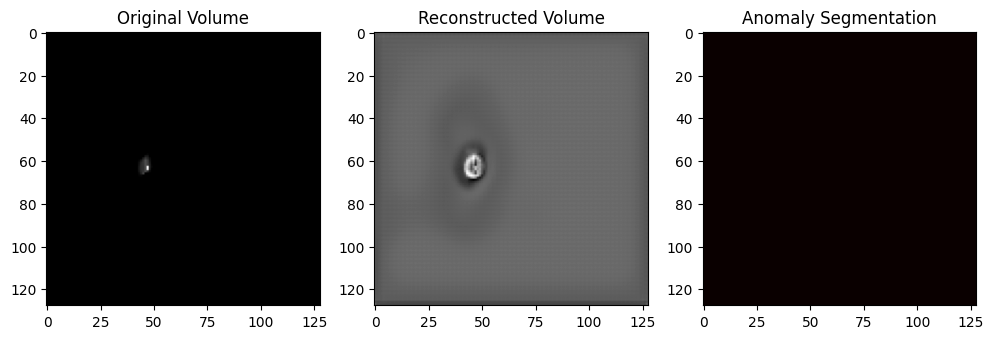

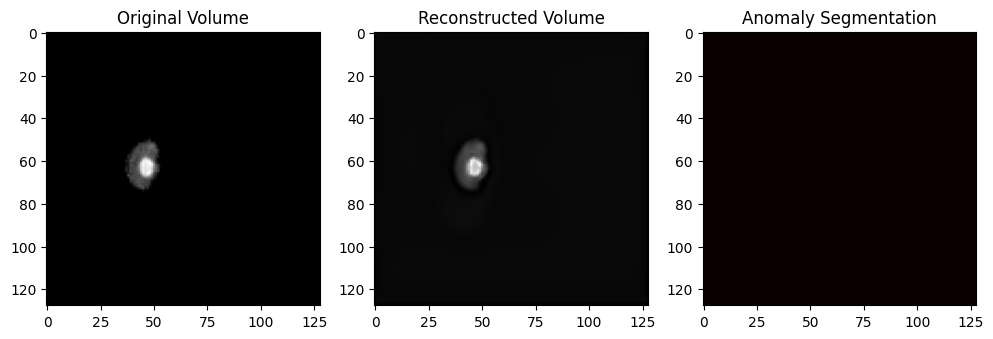

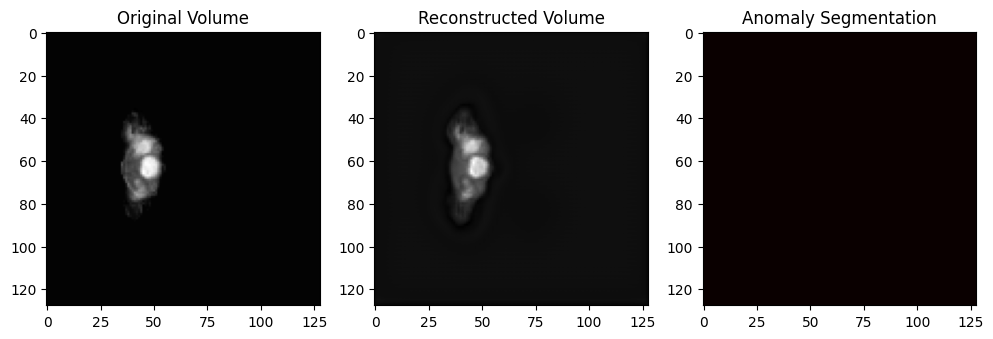

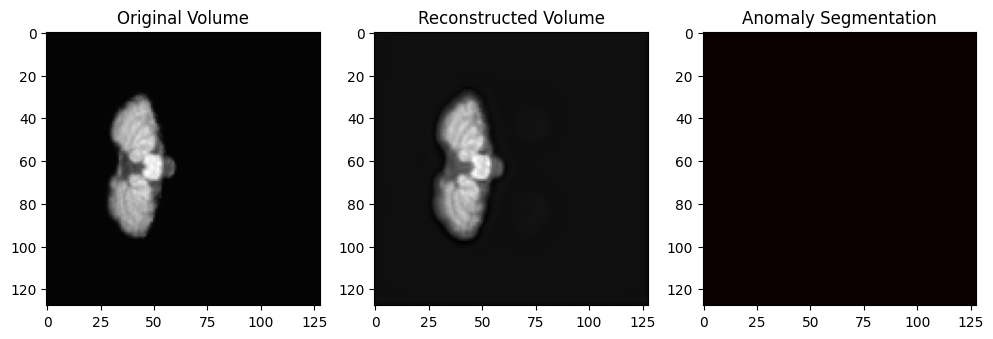

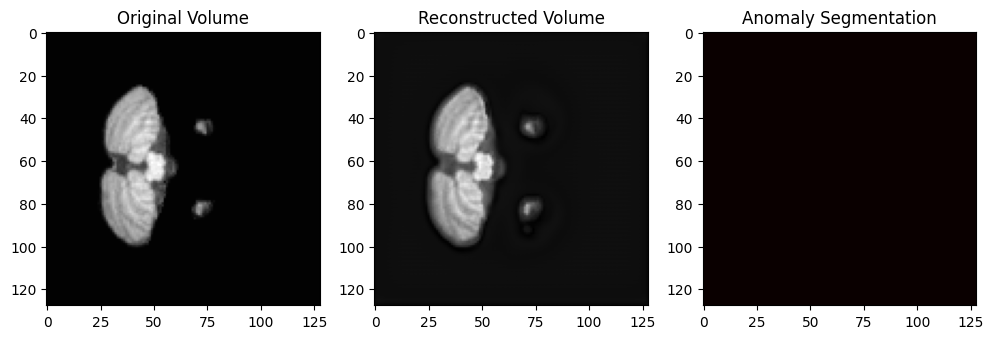

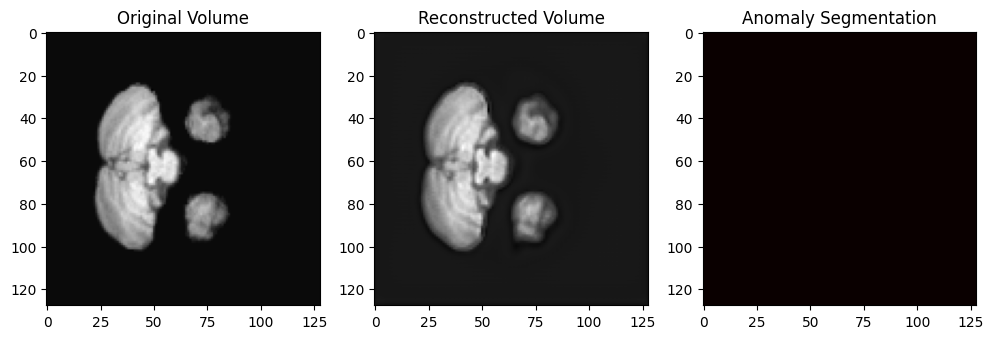

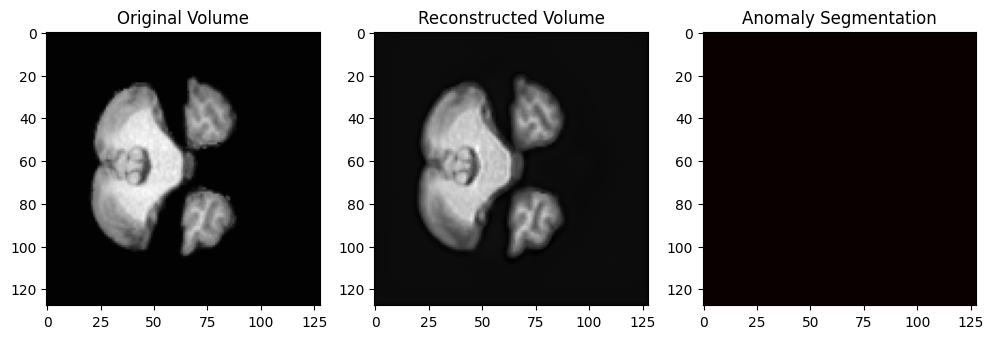

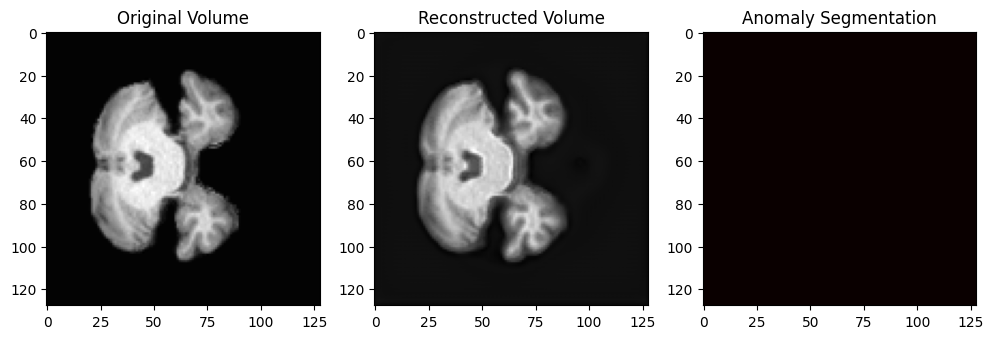

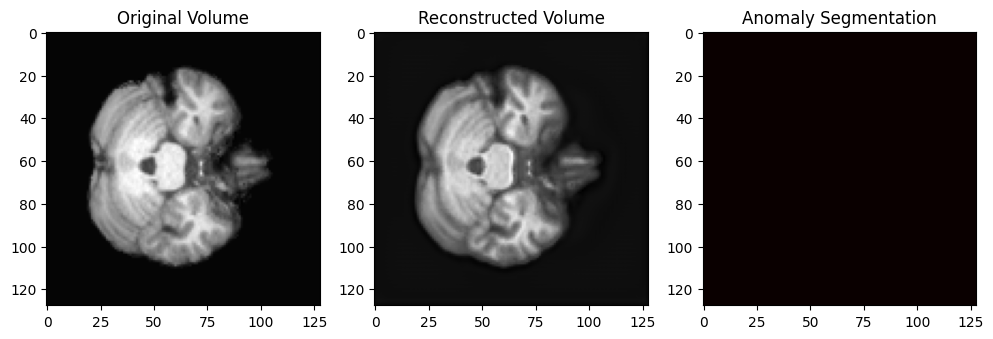

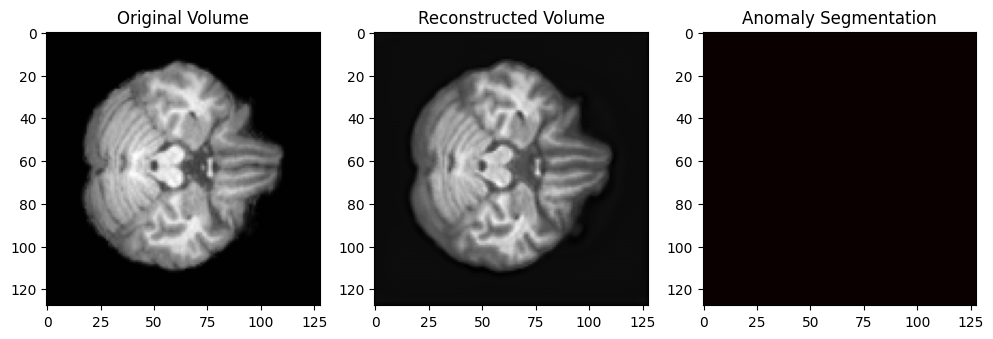

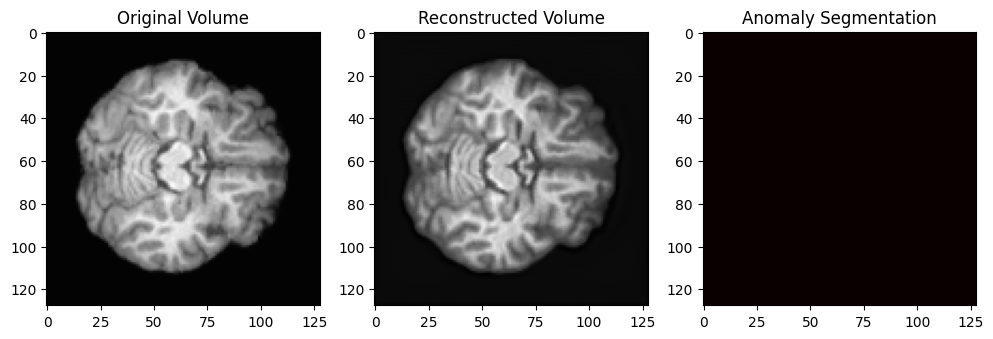

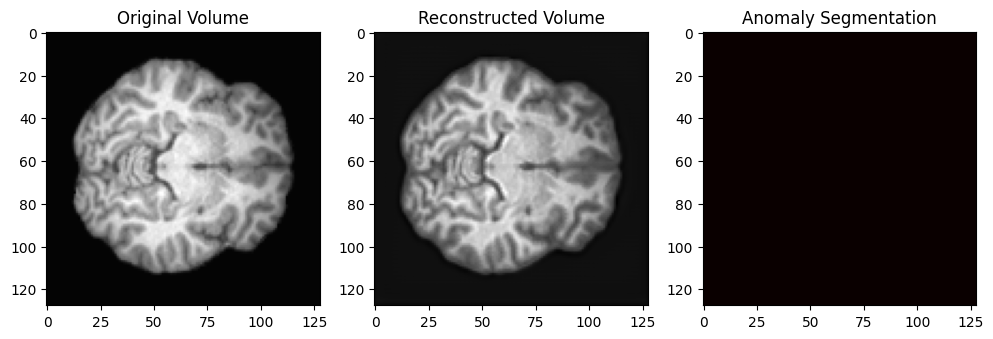

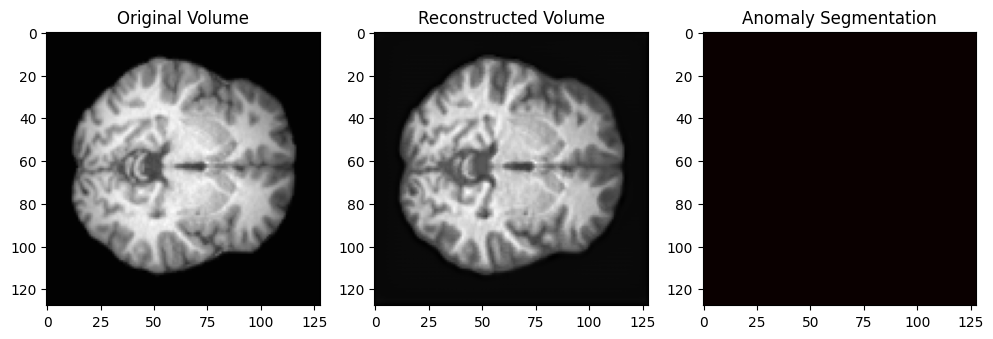

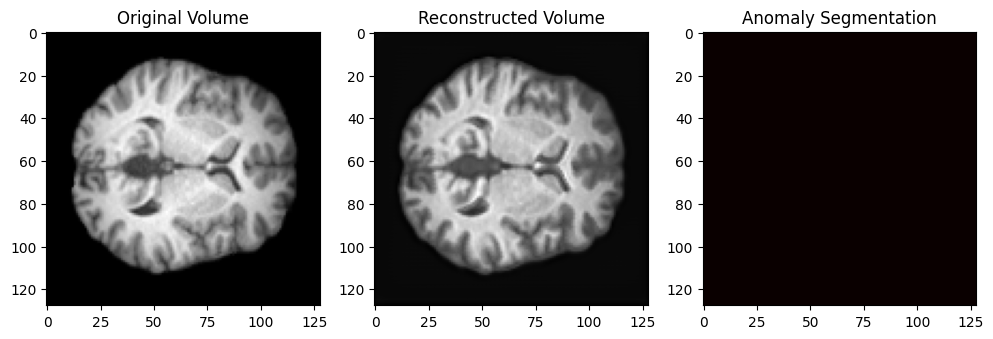

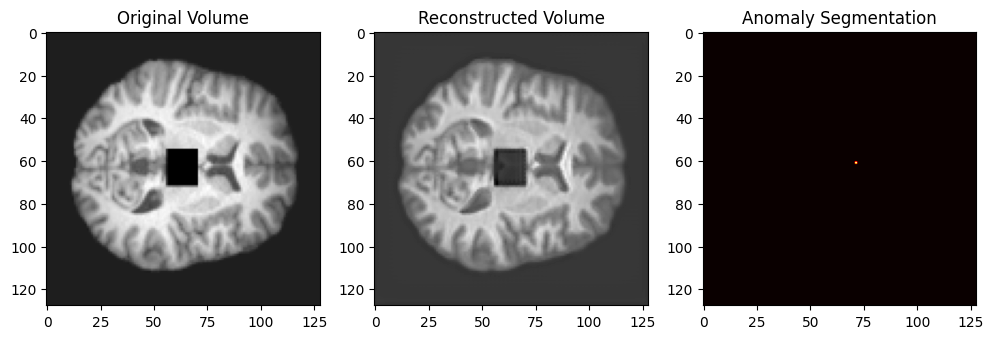

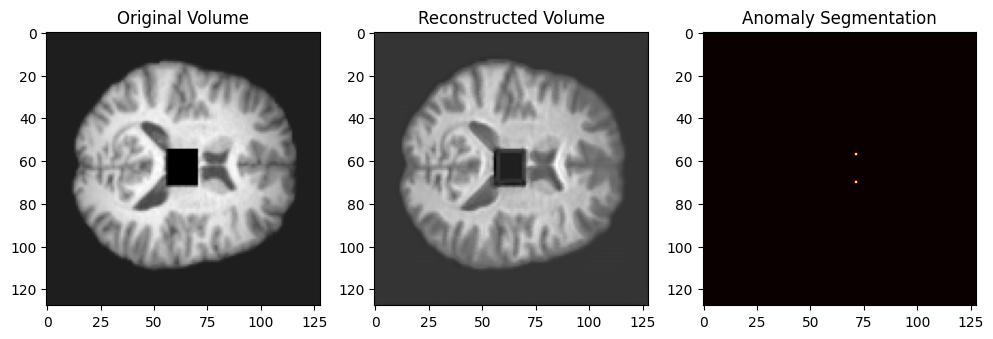

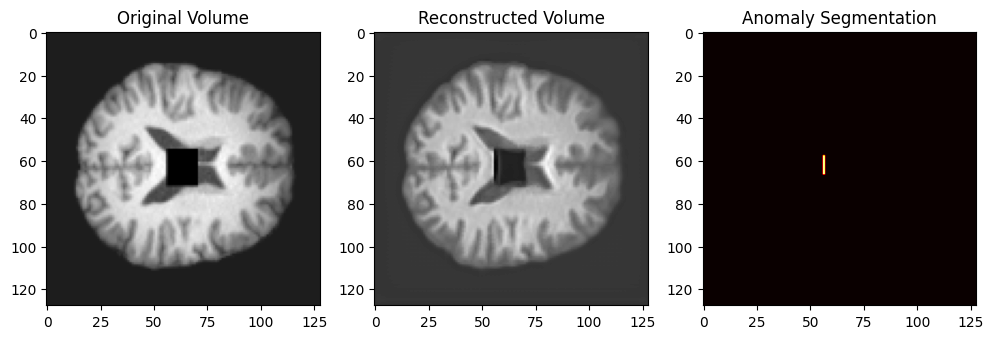

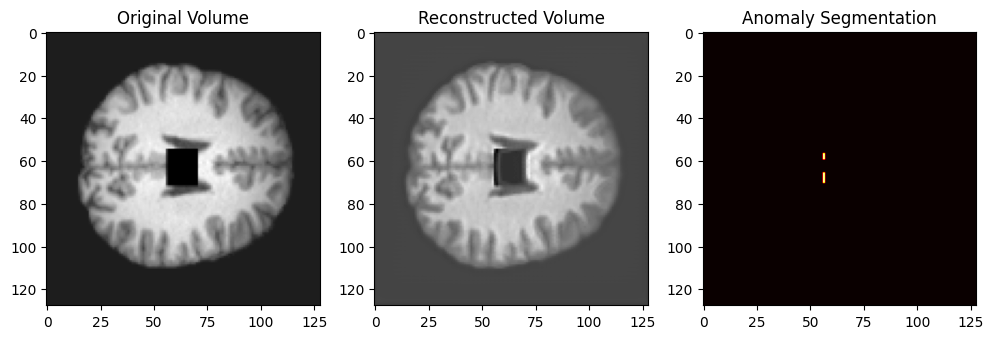

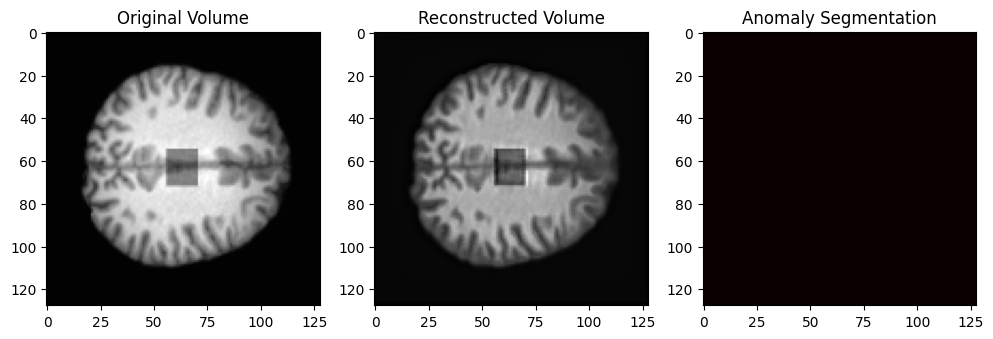

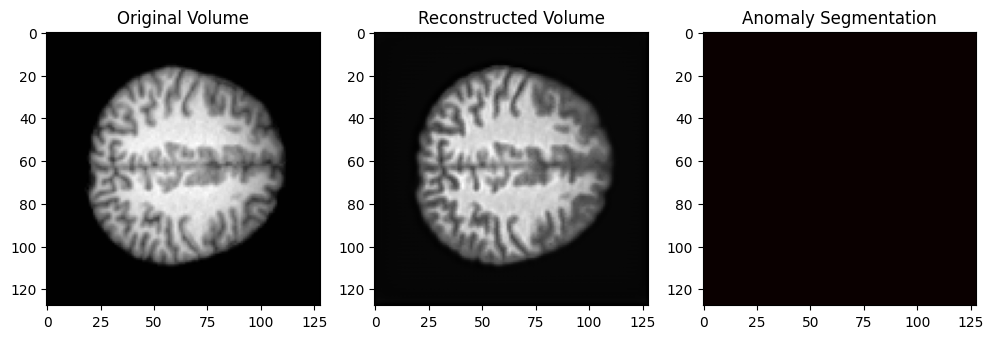

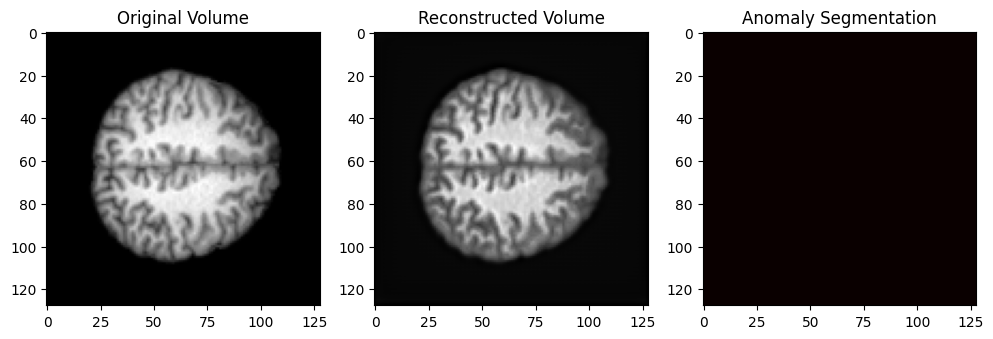

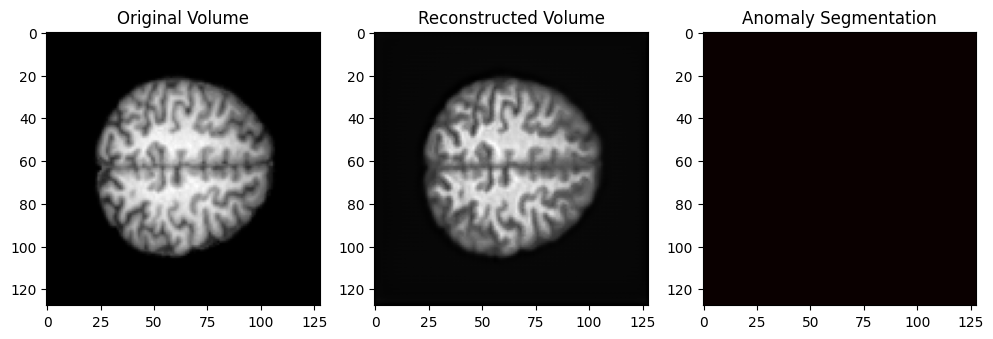

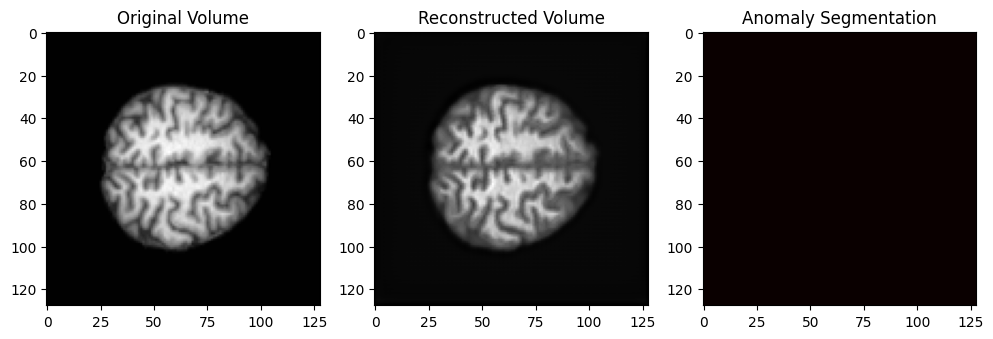

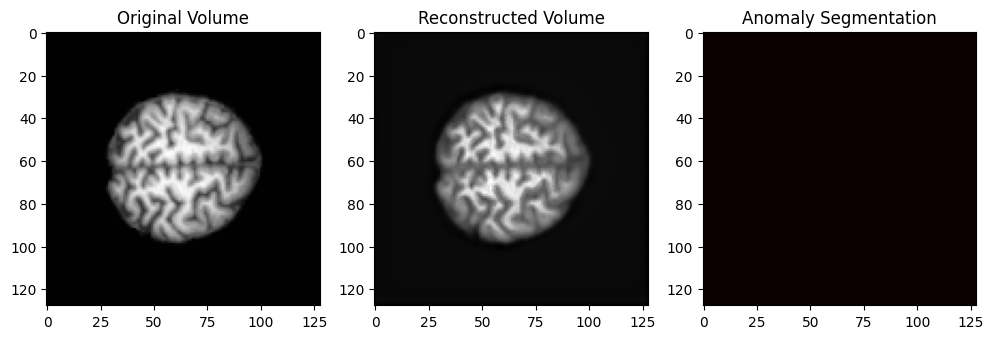

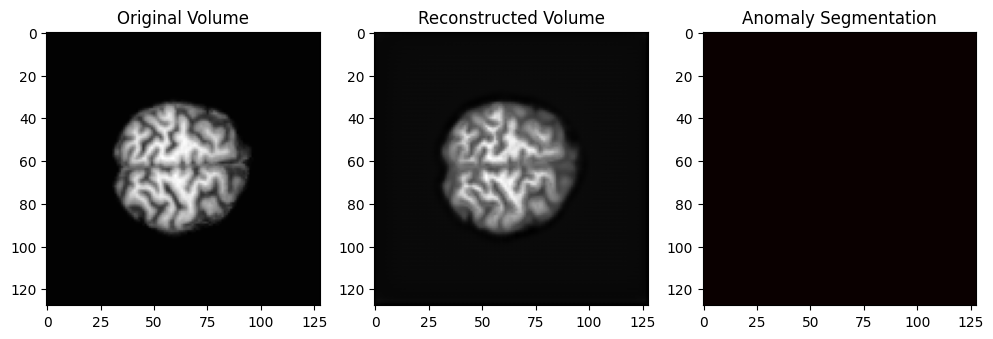

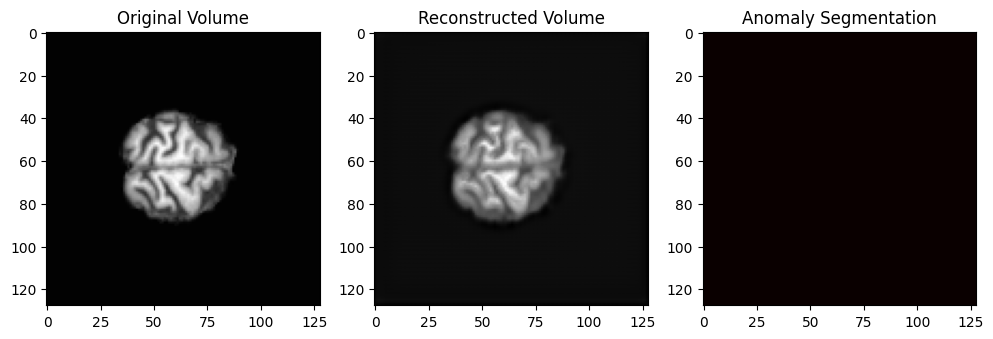

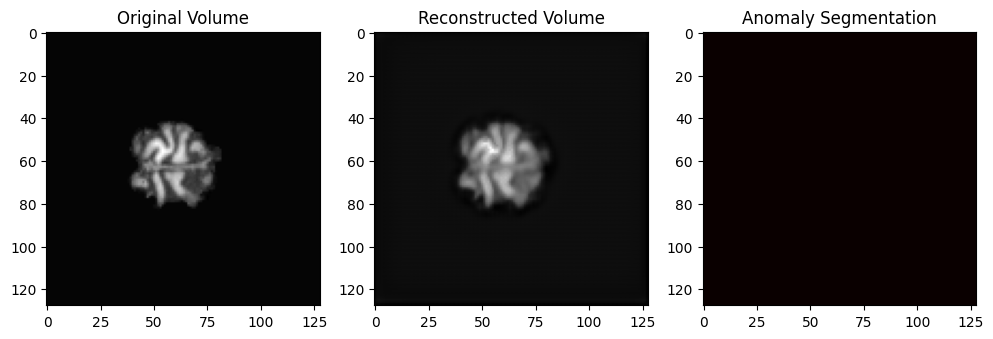

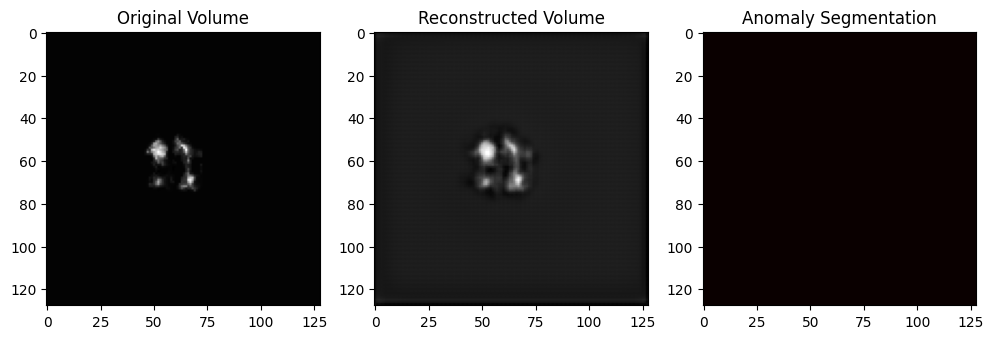

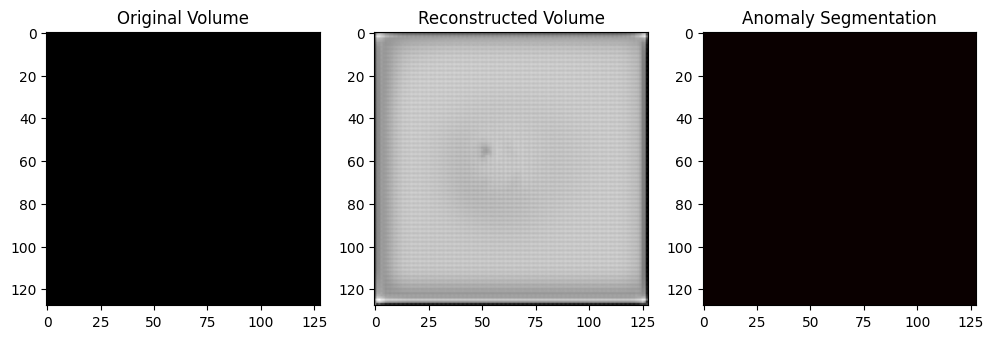

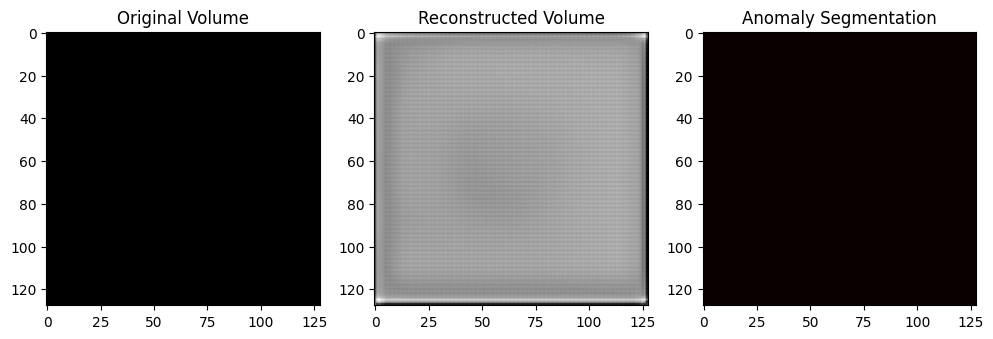

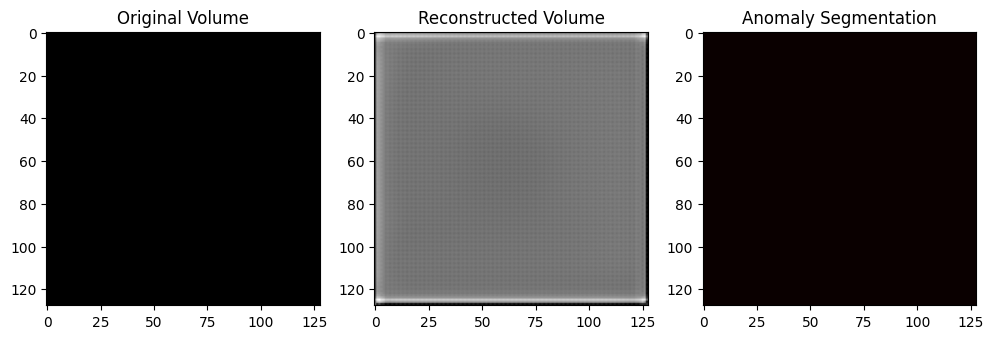

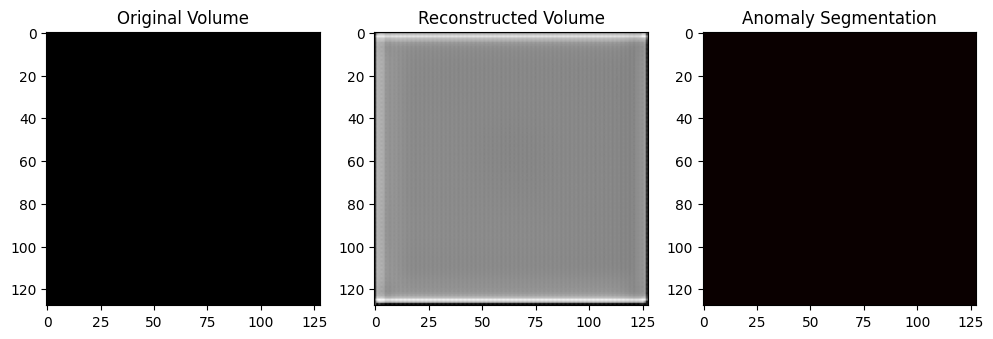

In [28]:
for i in range(0, 128, 4):
    visualize_segmentation_full_volume(test_volume, reconstructed_volume, anomaly_mask, slice_idx=i)

Save and Load Model

In [ ]:
model_path = '/kaggle/working/model2.pth'

# Save the models to the Kaggle working directory
torch.save(model.state_dict(), model_path)

print("Models saved successfully!")

In [ ]:
'''model_path = '/kaggle/working/model.pth'
loaded_model = AttentionUNet3D(in_channels=1, out_channels=1)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()
print("Models loaded successfully!")'''


In [ ]:
'''
test_volume = np.load("/kaggle/input/openbhb/val_quasiraw/sub-186653896119_preproc-quasiraw_T1w.npy")  
test_volume = torch.from_numpy(test_volume).float()  # Volume shape: (1, 1, 182, 218, 182)
test_volume = torch.squeeze(test_volume, 0)  # Shape becomes (1, 182, 218, 182)

# Normalize the volume
test_volume = (test_volume - test_volume.min()) / (test_volume.max() - test_volume.min() + 1e-8)

test_volume = crop(test_volume)

# Resize to the target shape (128x128x128)
test_volume = F.interpolate(test_volume.unsqueeze(0), size=(128, 128, 128), mode='trilinear').squeeze(0)'''


In [ ]:
'''
reconstructed_volume, anomaly_score, anomaly_mask = test_anomaly_detection_full_volume(test_volume, loaded_model)

print(f"Anomaly Score: {anomaly_score:.4f}")'''


Loading and Testing

In [6]:
import torch

checkpoint = torch.load("/kaggle/working/checkpoint_Aunet/best_model1.pth", weights_only=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AttentionUNet3D(in_channels=1, out_channels=1).to(device)
# model = UNETR_Reconstruction(in_channels=1, img_size=(16, 128, 128), feature_size=32, norm_name='instance')
model = model.to(device)

model.load_state_dict(checkpoint['model_state_dict'])

model.eval()

print("Model loaded successfully.")

Model loaded successfully.


In [ ]:
'''device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_path = '/kaggle/working/checkpoint_Aunet/best_model1.pth'
loaded_model = AttentionUNet3D(in_channels=1, out_channels=1)
loaded_model.load_state_dict(torch.load(model_path, weights_only=True))
loaded_model.eval()
print("Models loaded successfully!")'''

In [ ]:
import nibabel as nib  # For loading MRI/CT scan data in NIfTI format
import os

In [ ]:
t1ce_path = os.path.join('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii')

t1ce_img = nib.load(t1ce_path).get_fdata()

In [ ]:
# data = torch.tensor(t1ce_img)
import torch

def rotate_180_180(volume):
    """
    Rotates a 3D volume 180 degrees along the first and third dimensions.

    Args:
        volume (torch.Tensor): The input 3D volume.

    Returns:
        torch.Tensor: The rotated 3D volume.
    """

    volume = volume.flip(dims=(0, 2))
    return volume

In [ ]:
# test_volume = np.load("/kaggle/input/openbhb/val_quasiraw/sub-398276186058_preproc-quasiraw_T1w.npy")  
test_volume = torch.from_numpy(t1ce_img).float()  # Volume shape: (1, 1, 182, 218, 182)
test_volume = torch.squeeze(test_volume, 0)  # Shape becomes (1, 182, 218, 182)

# Normalize the volume
test_volume = (test_volume - test_volume.min()) / (test_volume.max() - test_volume.min() + 1e-8)

test_volume = crop_brain_scan(test_volume)
test_volume = rotate_180_180(test_volume)

# test_volume = add_noise_to_cube(test_volume)


# Resize to the target shape (128x128x128)
test_volume = F.interpolate(test_volume.unsqueeze(0), size=(128, 128, 128), mode='trilinear').squeeze(0)

In [ ]:
reconstructed_volume, anomaly_score, anomaly_mask = test_anomaly_detection_full_volume(test_volume, model)

print(f"Anomaly Score: {anomaly_score:.4f}")

In [ ]:
for i in range(0, 128, 4):
    visualize_segmentation_full_volume(test_volume, reconstructed_volume, anomaly_mask, slice_idx=i)